(sec:softdtw)=
# Soft-DTW

One strong limitation of Dynamic Time Warping is that it cannot be
differentiated everywhere because of the min operator that is used throughout
the computations.
This limitation is especially problematic given the importance of
gradient-based optimization in Machine Learning.

Soft-DTW {cite}`cuturi2017soft` has been introduced as a way to mitigate this
limitation.

## Definition

The formal definition for soft-DTW is the following:

\begin{equation}
\text{soft-}DTW^{\gamma}(\mathbf{x}, \mathbf{x}^\prime) =
    \min_{\pi \in \mathcal{A}(\mathbf{x}, \mathbf{x}^\prime)}{}^\gamma
        \sum_{(i, j) \in \pi} d(x_i, x^\prime_j)^2
\label{eq:softdtw}
\end{equation}

where $\min{}^\gamma$ is the soft-min operator parametrized by a smoothing
factor $\gamma$.

````{admonition} A note on soft-min

The soft-min operator $\min{}^\gamma$ is defined as:

\begin{equation}
    \min{}^\gamma(a_1, \dots, a_n) = - \gamma \log \sum_i e^{-a_i / \gamma}
\end{equation}

Note that when gamma tends to $0^+$, the term corresponding to the lower $a_i$
value will dominate other terms in the sum, and the soft-min then tends to the
hard minimum.
````

Typically, we have:

\begin{equation}
    \text{soft-}DTW^{\gamma}(\mathbf{x}, \mathbf{x}^\prime)
    \xrightarrow{\gamma \to 0^+} DTW(\mathbf{x}, \mathbf{x}^\prime)^2 \, .
\end{equation}
However, contrary to DTW, soft-DTW -- being differentiable everywhere -- can be
used as a loss in neural networks.
This use-case is discussed in more details in our {ref}`sec:forecasting`
section.

## Soft-Alignment Path

Let us denote by $A_\gamma$ the "soft path" matrix that informs, for each pair
$(i, j)$, how much it will be taken into account in the matching.
$A_\gamma$ can be interpreted as a weighted average of paths in
$\mathcal{A}(\mathbf{x}, \mathbf{x}^\prime)$:

\begin{eqnarray}
A_\gamma =& \, \mathbb{E}_{\gamma}[A] \\
=& \, \frac{1}{k_{\mathrm{GA}}^{\gamma}(\mathbf{x}, \mathbf{x}^\prime)} \sum_{\pi \in \mathcal{A}(\mathbf{x}, \mathbf{x}^\prime)} e^{-\langle A_\pi, D_2(\mathbf{x}, \mathbf{x}^\prime) / \gamma\rangle} A_\pi \, ,
\end{eqnarray}

where $k_{\mathrm{GA}}^{\gamma}(\mathbf{x}, \mathbf{x}^\prime)$ can be
seen as a normalization factor (see [](sec:gak) section for more
details) and $D_2(\mathbf{x}, \mathbf{x}^\prime)$ is a matrix that stores
squared distances $d(x_i, x^\prime_j)^2$

In [1]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy

plt.ion()

def plot_constraints(title, sz):
    for pos in range(sz):
        plt.plot([-.5, sz - .5], [pos + .5, pos + .5],
                 color='w', linestyle='-', linewidth=3)
        plt.plot([pos + .5, pos + .5], [-.5, sz - .5],
                 color='w', linestyle='-', linewidth=3)
    plt.xticks([])
    plt.yticks([])
    plt.gca().axis("off")
    plt.title(title)
    plt.tight_layout()

def plot_path(s_y1, s_y2, path_matrix, title):
    sz = s_y1.shape[0]

    # definitions for the axes
    left, bottom = 0.01, 0.1
    w_ts = h_ts = 0.2
    left_h = left + w_ts + 0.02
    width = height = 0.65
    bottom_h = bottom + height + 0.02

    rect_s_y = [left, bottom, w_ts, height]
    rect_gram = [left_h, bottom, width, height]
    rect_s_x = [left_h, bottom_h, width, h_ts]

    ax_gram = plt.axes(rect_gram)
    ax_s_x = plt.axes(rect_s_x)
    ax_s_y = plt.axes(rect_s_y)

    ax_gram.imshow(path_matrix[::-1], origin='lower')
    ax_gram.axis("off")
    ax_gram.autoscale(False)

    ax_s_x.plot(numpy.arange(sz), s_y2, "b-", linewidth=3.)
    ax_s_x.axis("off")
    ax_s_x.set_xlim((0, sz - 1))

    ax_s_y.plot(- s_y1[::-1], numpy.arange(sz), "b-", linewidth=3.)
    ax_s_y.axis("off")
    ax_s_y.set_ylim((0, sz - 1))


    plt.title(title)

    plt.tight_layout()
    plt.show()

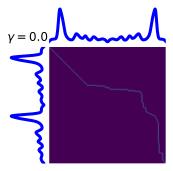

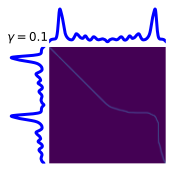

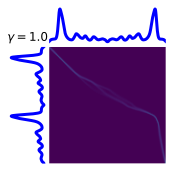

In [2]:
import numpy
from tslearn import metrics

numpy.random.seed(0)

s_x = numpy.loadtxt("../data/sample_series.txt")
s_y1 = numpy.concatenate((s_x, s_x)).reshape((-1, 1))
s_y2 = numpy.concatenate((s_x, s_x[::-1])).reshape((-1, 1))
sz = s_y1.shape[0]

for gamma in [0., .1, 1.]:
    alignment, sim = metrics.soft_dtw_alignment(s_y1, s_y2, gamma=gamma)
    plt.figure(figsize=(2.5, 2.5))
    plot_path(s_y1, s_y2, alignment, title="$\\gamma={:.1f}$".format(gamma))

$A_\gamma$ can be computed with complexity $O(mn)$ and there is a link between
this matrix and the gradients of the soft-DTW similarity measure:

\begin{equation}
\nabla_{\mathbf{x}} \text{soft-}DTW^{\gamma}(\mathbf{x}, \mathbf{x}^\prime) =
    \left(\frac{\partial D_2(\mathbf{x}, \mathbf{x}^\prime)}{\partial \mathbf{x}} \right)^T A_\gamma
\end{equation}

## Properties

As discussed in {cite}`janati2020spatio`, soft-DTW is not invariant to time
shifts, as is DTW.
Suppose $\mathbf{x}$ is a time series that is constant except for a motif that
occurs at some point in the series, and let us denote by $\mathbf{x}_{+k}$ a
copy of $\mathbf{x}$ in which the motif is temporally shifted by $k$ timestamps.
Then the quantity

\begin{equation*}
\left| \text{soft-}DTW^{\gamma}(\mathbf{x}, \mathbf{x}_{+k}) - \text{soft-}DTW^{\gamma}(\mathbf{x}, \mathbf{x}) \right|
\end{equation*}

grows linearly with $\gamma k^2$.
The reason behind this sensibility to time shifts is that soft-DTW provides a
weighted average similarity score across all alignment paths (where stronger
weights are assigned to better paths), instead of focusing on the single best
alignment as done in DTW.

Another important property of soft-DTW is that is has a "denoising effect", in
the sense that, for a given time series $\mathbf{y}$, the minimizer of
$\text{soft-}DTW^{\gamma}(\mathbf{x}, \mathbf{y})$ is not $\mathbf{y}$
itself but rather a smoothed version:

```{figure} ../fig/denoising_sdtw.*
---
width: 50%
name: denoising_sdtw
---
Denoising effect of soft-DTW.
Here, the optimization problem is
$\min_\mathbf{x} \text{soft-}DTW^{\gamma}(\mathbf{x}, \mathbf{y})$
and $\mathbf{y}$ is used as an initialization for the gradient descent.
This Figure is taken from {cite}`blondelmensch2020`.
```

## Related Similarity Measures

In {cite}`blondelmensch2020`, new similarity measures are defined, that rely on
soft-DTW.

First, **soft-DTW divergence** is defined as:

\begin{equation}
    D^\gamma (\mathbf{x}, \mathbf{x}^\prime) =
        \text{soft-}DTW^{\gamma}(\mathbf{x}, \mathbf{x}^\prime)
        - \frac{1}{2} \left(
                \text{soft-}DTW^{\gamma}(\mathbf{x}, \mathbf{x}) +
                \text{soft-}DTW^{\gamma}(\mathbf{x}^\prime, \mathbf{x}^\prime)
            \right)
\end{equation}

and this divergence has the advantage of being minimized for
$\mathbf{x} = \mathbf{x}^\prime$ (and being exactly 0 in that case).

Second, another interesting similarity measure introduced in the same paper is
the **sharp soft-DTW** which is:

\begin{equation}
    \text{sharp-soft-}DTW^{\gamma} (\mathbf{x}, \mathbf{x}^\prime) =
        \langle A_\gamma,  D_2(\mathbf{x}, \mathbf{x}^\prime) \rangle
\end{equation}

Note that a **sharp soft-DTW divergence** can be derived from this
(with a similar approach as for $D^\gamma$), which has the extra benefit
(over the sharp soft-DTW) of
being minimized at $\mathbf{x} = \mathbf{x}^\prime$.

Further note that, by pushing $\gamma$ to the $+\infty$ limit in this formula,
one gets:

\begin{equation}
\text{sharp-soft-}DTW^{\gamma}(\mathbf{x}, \mathbf{x}^\prime)
    \xrightarrow{\gamma \to +\infty}
    \left\langle A_\infty, D_2(\mathbf{x}, \mathbf{x}^\prime) \right\rangle \, ,
\end{equation}

where $A_\infty$ tends to favor diagonal matches:

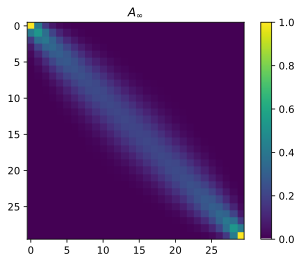

In [3]:
def delannoy(m, n):
  numbers = numpy.zeros((m + 1, n + 1), dtype=numpy.float64)
  numbers[0, 0] = 1
  for i in range(1, m + 1):
    for j in range(1, n + 1):
      numbers[i, j] = numbers[i - 1, j - 1] + numbers[i, j - 1] + numbers[i - 1, j]
  return numbers[1:, 1:]

m = n = 30
delannoy_numbers = delannoy(m, n)
weight_matrix = delannoy_numbers * delannoy_numbers[::-1, ::-1] / delannoy_numbers[-1, -1]

fig = plt.figure()
plt.imshow(weight_matrix)
plt.colorbar()
plt.title("$A_\infty$")
plt.show()

## Barycenters

Also, **barycenters** for the soft-DTW geometry can be estimated by
minimization of the corresponding loss (_cf._ Equation {eq}`eq:barycenter`)
through gradient descent.
In such case, the parameters to be optimized are the coordinates of the
barycenter.
This is illustrated in the example below:

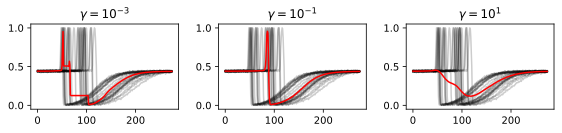

In [4]:
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.barycenters import softdtw_barycenter

X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_train = X_train[y_train == 1]

plt.figure(figsize=(8, 2))
for i, pow in enumerate([-3, -1, 1]):
    bar = softdtw_barycenter(X=X_train, gamma=10 ** pow)

    plt.subplot(1, 3, i + 1)
    plt.title("$\\gamma = 10^{%d}$" % pow)
    for ts in X_train:
        plt.plot(ts.ravel(), "k-", alpha=.2)
    plt.plot(bar.ravel(), "r-")

plt.tight_layout()

Note how large values of $\gamma$ tend to smooth out the motifs from the input
time series.
The noisy barycenter obtained for low $\gamma$ can be explained by the fact
that low values of $\gamma$ lead to a similarity measure that is
less smooth (with the extreme case $\gamma = 0$ for which DTW is retrieved and
the function faces differentiability issues), making the optimization problem
harder.


## References

```{bibliography} ../../references.bib
:filter: docname in docnames
```